# Tests Realised for Thymio Project

In [1]:
import sys
import os
import yaml
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tdmclient.notebook
from IPython.display import display, clear_output


In [2]:
# Get current directory
current_dir = os.getcwd()

# Assuming you're in variance_calculation folder and scripts is at the same level:
# Add the parent directory to system path to access scripts folder
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

config_path = os.path.join(parent_dir, 'config', 'config.yaml')

# Load the config file
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
    
from scripts.vision import Vision
from utils import utils

In [3]:
# Extract webcam configuration
webcam_config = config['webcam']
webcam_device_id = webcam_config['device_id']
webcam_resolution = tuple(webcam_config['resolution'])
webcam_padding = webcam_config['padding']

# Convert camera matrix from list to numpy array
webcam_matrix = np.array(webcam_config['matrix'])

# Convert distortion coefficients from list to numpy array
webcam_distortion = np.array(webcam_config['distortion'])

# Get world dimensions from world config
world_config = config['world']
world_width = world_config['width']
world_height = world_config['height']

# Scale factor 
factor_scale = webcam_resolution[1] / world_width

# Scale speed
speed_scale = config['thymio']['speed_scale']

# Thymio width
thymio_width = config['thymio']['size']['width']
wheel_radius = config['thymio']['size']['wheel_radius']


## Speed Conversion Test

In [34]:
await tdmclient.notebook.start()
print("Successfully connected to Thymio.")

@tdmclient.notebook.sync_var
def motor_move(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0

Successfully connected to Thymio.


In [35]:
def calculate_speed(wheel_radius, num_rotations, time_seconds):
    circumference = 2 * wheel_radius * np.pi     # 2 * π * radius
    distance = circumference * num_rotations     # total distance traveled
    speed = distance / time_seconds              # speed in mm/s
    return speed

In [39]:
motor_stop()

In [41]:
# Set the speed of the robot
measuremend_time = 10
speed_settings = [50, 75, 100, 150, 200]
speed_to_coeffs = {speed: [] for speed in speed_settings}  # Dictionary to store coeffs for each speed
mean_coeffs = {}  # Dictionary to store mean coeff for each speed

print("Starting speed calibration measurements")
for speed_setting in speed_settings:
    for trial in range(3):
        # In your loop:
        clear_output(wait=True)  # This clears the previous output
        display(f"Trial {trial + 1} for speed setting: {speed_setting}")
        input("Press Enter to start counting rotations...")
        motor_move(speed_setting, speed_setting)
        time.sleep(measuremend_time)
        motor_stop()
        rotations = float(input(f"Enter number of rotations counted in {measuremend_time} seconds: "))
    
        # Calculate actual speed in mm/s
        speed_mms = calculate_speed(wheel_radius, rotations, measuremend_time)
        
        # Calculate conversion coefficient (setting/actual_speed)
        coeff = speed_setting / speed_mms
        speed_to_coeffs[speed_setting].append(coeff)

    # Calculate mean coefficient for this speed
    mean_coeffs[speed_setting] = np.mean(speed_to_coeffs[speed_setting])

# Print results
print("\nConversion coefficients for each speed:")
print("Speed Setting | Mean Coefficient | Individual Trials")
print("-------------|------------------|------------------")
for speed, coeffs in speed_to_coeffs.items():
    trials_str = ", ".join([f"{c:.4f}" for c in coeffs])
    print(f"{speed:12d} | {mean_coeffs[speed]:15.4f} | {trials_str}")

overall_mean = np.mean([coeff for coeffs in speed_to_coeffs.values() for coeff in coeffs])
print(f"\nOverall mean conversion coefficient: {overall_mean:.4f}")

'Trial 3 for speed setting: 200'


Conversion coefficients for each speed:
Speed Setting | Mean Coefficient | Individual Trials
-------------|------------------|------------------
          50 |          2.4269 | 2.4114, 2.3826, 2.4868
          75 |          2.7130 | 2.7129, 2.6884, 2.7378
         100 |          2.9474 | 2.9473, 2.9256, 2.9693
         150 |          2.8742 | 2.8972, 2.8832, 2.8421
         200 |          2.9861 | 2.9804, 3.0029, 2.9749

Overall mean conversion coefficient: 2.7895


In [42]:
# We take only the 100, 150 and 200 speed settings since the mean coefficient doesnt vary much
# Filter speeds >= 100 and get all their coefficients
stable_coeffs = [coeff 
                 for speed, coeffs in speed_to_coeffs.items() 
                 for coeff in coeffs 
                 if speed >= 100]

# Calculate mean
stable_mean = np.mean(stable_coeffs)

# Print results
print("\nStable speeds coefficients (speed >= 100):")
print("Speed Setting | Individual Trials")
print("-------------|------------------")
for speed in [100, 150, 200]:
    trials_str = ", ".join([f"{c:.4f}" for c in speed_to_coeffs[speed]])
    print(f"{speed:12d} | {trials_str}")

print(f"\nMean coefficient for stable speeds: {stable_mean:.4f}")


Stable speeds coefficients (speed >= 100):
Speed Setting | Individual Trials
-------------|------------------
         100 | 2.9473, 2.9256, 2.9693
         150 | 2.8972, 2.8832, 2.8421
         200 | 2.9804, 3.0029, 2.9749

Mean coefficient for stable speeds: 2.9359


In [43]:
await tdmclient.notebook.stop()

## Camera Covariance Test

In [ ]:
vision = Vision(
device_id=webcam_device_id,
camera_matrix=webcam_matrix,
dist_coeffs=webcam_distortion,
resolution=webcam_resolution,
padding=webcam_padding,
scale_factor=factor_scale,
world_width=world_width,
world_height=world_height 
)

In [15]:
# Initialize arrays to store positions and orientations
n_samples = 500
positions = np.zeros((n_samples, 2))  # For x,y positions
orientations = np.zeros(n_samples)    # For orientation values


In [ ]:
vision.connect_webcam()

try:
   # Collect data
    print("Collecting camera data...")
    for i in tqdm(range(n_samples)):
        original_frame, _, pos, orientation, _, found_pos, _ = vision.get_frame()
        
        if found_pos:
            positions[i] = pos[:2] # Store x,y positions
            orientations[i] = orientation # Store orientation values
        time.sleep(0.1)
except KeyboardInterrupt:
    pass
finally:
    vision.cleanup_webcam()

  0%|          | 0/500 [00:00<?, ?it/s]

In [45]:
# Calculate variances (covariances with themselves)
pos_mean = np.mean(positions, axis=0)
x_variance = np.var(positions[:, 0])
y_variance = np.var(positions[:, 1])
orientation_variance = np.var(orientations)

print("\nCovariance Results:")
print(f"X position variance: {x_variance:.8f}")
print(f"Y position variance: {y_variance:.8f}")
print(f"Orientation variance: {orientation_variance:.8f}")


Covariance Results:
X position variance: 0.05278737
Y position variance: 0.03885833
Orientation variance: 0.00000526


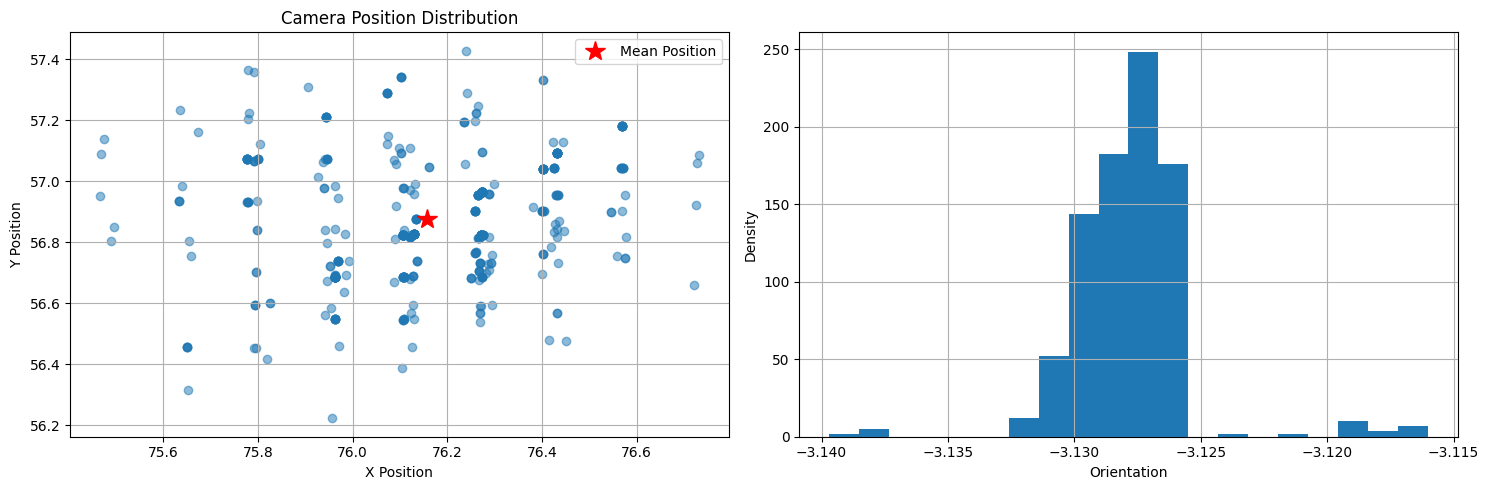

In [ ]:
# Create visualization
plt.figure(figsize=(15, 5))

# Position scatter plot
plt.subplot(121)
plt.scatter(positions[:, 0], positions[:, 1], alpha=0.5)
plt.plot(pos_mean[0], pos_mean[1], 'r*', markersize=15, label='Mean Position')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Camera Position Distribution')
plt.grid(True)
plt.legend()


# Orientation histogram
plt.subplot(122)
plt.hist(orientations, bins=20, density=True)
plt.xlabel('Orientation')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout()

# Save in different formats
#plt.savefig('camera_analysis.png', dpi=300, bbox_inches='tight')  # PNG format

## Translation Speed Linear Covariance
We use the camera to get the inital pos and the end pos after a certain time. We calculate the speed with the camera and we calculate the speed that has been set to the thymio (speed / speed_conversion to get mm/s)

In [77]:
await tdmclient.notebook.start()
print("Successfully connected to Thymio.")

@tdmclient.notebook.sync_var
def motor_move(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0

Successfully connected to Thymio.


In [5]:
vision = Vision(
device_id=webcam_device_id,
camera_matrix=webcam_matrix,
dist_coeffs=webcam_distortion,
resolution=webcam_resolution,
padding=webcam_padding,
scale_factor=factor_scale,
world_width=world_width,
world_height=world_height 
)

Vision Initialized


In [79]:
def calculate_actual_speed(initial_pos, final_pos, time_duration):
    distance = np.sqrt((final_pos[0] - initial_pos[0])**2 + 
                      (final_pos[1] - initial_pos[1])**2)
    return distance / time_duration

In [ ]:
# Test parameters
speeds = [100, 120, 140, 160, 180, 200]  # 6 speeds between 100 and 200
n_trials = 5  # Number of trials per speed
time_duration = 3  # seconds

# Arrays to store results
commanded_speeds = []  # Speeds we tell the robot to move at (in mm/s)
measured_speeds = []   # Speeds measured by the camera

vision.connect_webcam()

try:
    print("Starting velocity covariance measurements")
    for speed in speeds:
        for trial in range(n_trials):
            clear_output(wait=True)
            display(f"Testing speed {speed:.1f}, trial {trial + 1}/{n_trials}")
            input("Press Enter when Thymio is ready...")
            
            # Convert commanded speed to mm/s
            speed_mms = speed / speed_scale
            
            # Get initial position
            start_frame, _, initial_pos, orientation, _, found_pos, _ = vision.get_frame()
            if not found_pos:
                print("Warning: Robot not found at start!")
                continue
                
            # Move robot
            motor_move(speed, speed)
            start_time = time.time()
            motor_stop()
            # Get final position
            end_frame, _, final_pos, orientation, _, found_pos, _ = vision.get_frame()
            if not found_pos:
                print("Warning: Robot not found at end!")
                continue
            utils.display_frames(start_frame, end_frame, None)
            time.sleep(1)
            # Calculate actual speed
            actual_speed = calculate_actual_speed(initial_pos, final_pos, time_duration)
            
            # Store results
            commanded_speeds.append(speed_mms)
            measured_speeds.append(actual_speed)
            print(f"Commanded speed: {speed_mms:.2f} mm/s")
            print(f"Measured speed: {actual_speed:.2f} mm/s")
            time.sleep(1)
            
except KeyboardInterrupt:
    pass
finally:
    vision.cleanup_webcam()
    motor_stop()


'Testing speed 180.0, trial 5/5'

Sleeping for 3 seconds...


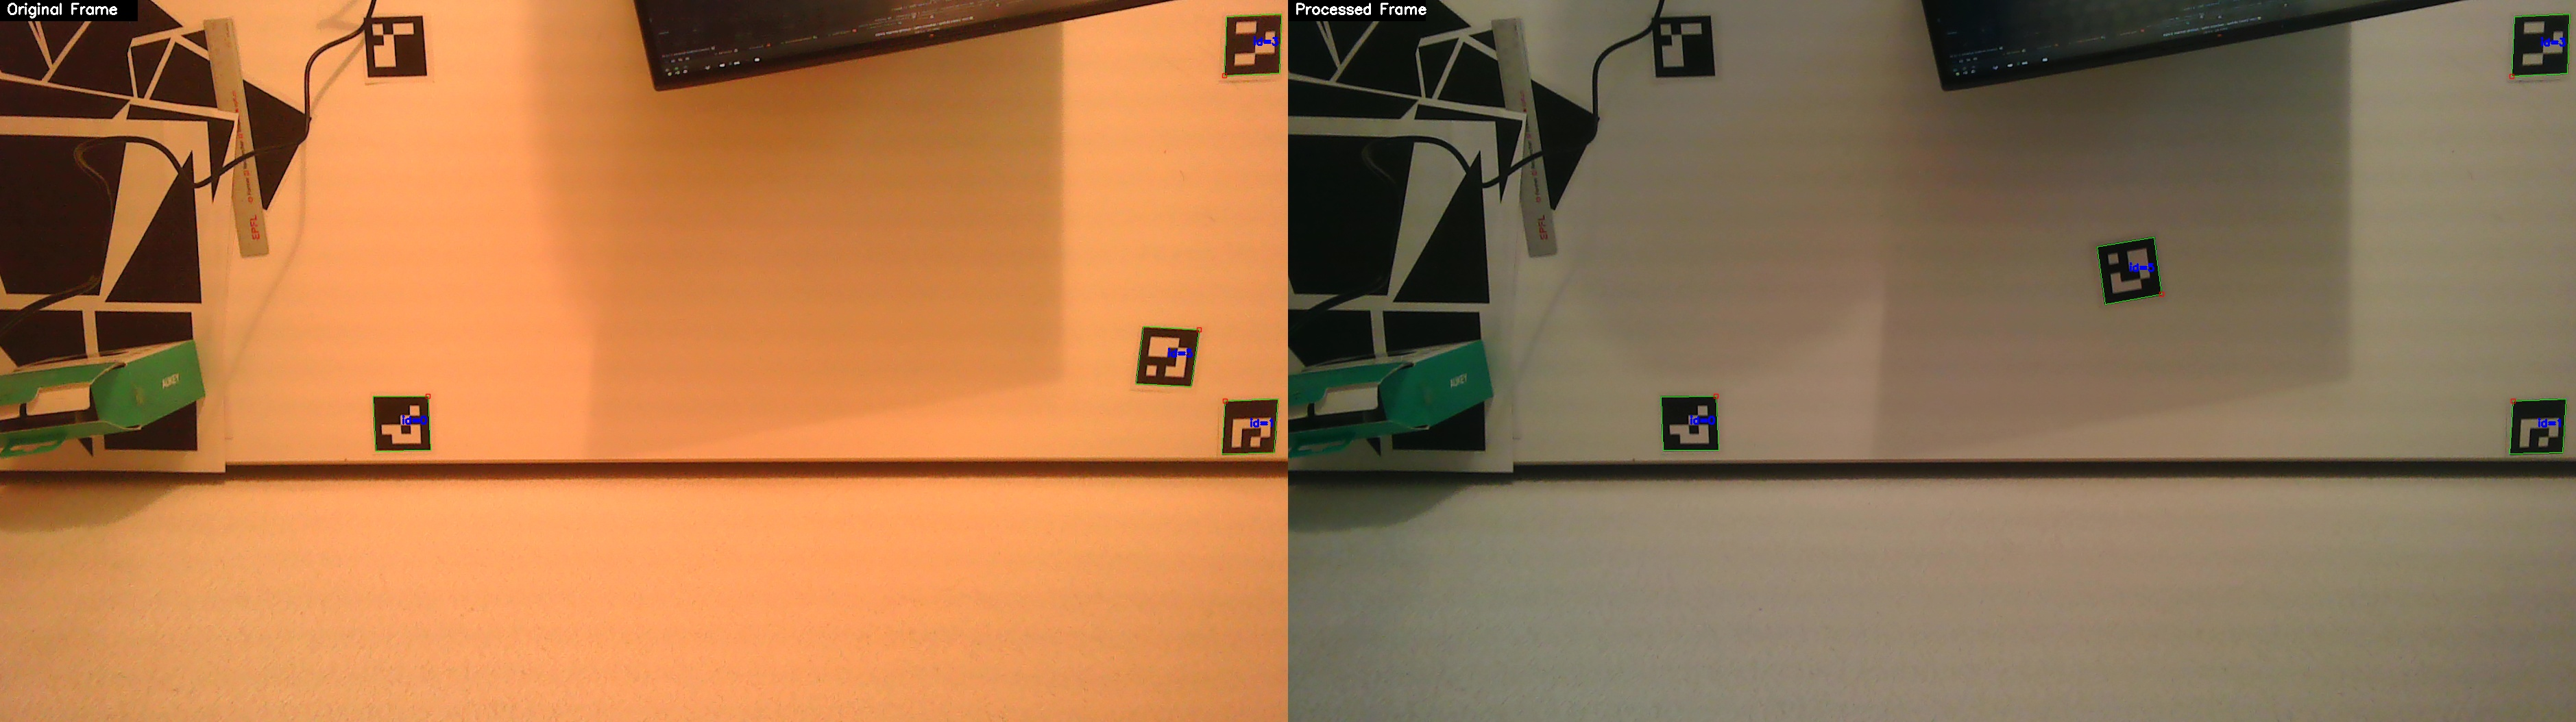

In [10]:
vision.connect_webcam()

try:
    start_time = time.time()
    start_frame, process_frame, pos, orientation, _, found_pos, _ = vision.get_frame()
    print("Sleeping for 3 seconds...")
    time.sleep(3)
    original_frame, _, pos, orientation, _, found_pos, _ = vision.get_frame()
    utils.display_frames(start_frame, original_frame, None)    
except KeyboardInterrupt:
    pass
finally:
    vision.cleanup_webcam()
    #motor_stop()

In [70]:
await tdmclient.notebook.stop()

In [10]:
def measure_velocity_noise(vision, target_velocities=[50, 75, 100, 150, 200], speed_scale=1, distance_scale=1, measurement_time=3.0):
    """
    Measure velocity accuracy using start and end positions.
    
    Args:
        vision: Vision system object with get_frame method
        target_velocities: List of target velocities in internal units
        speed_scale: Conversion factor from internal units to mm/s
        distance_scale: Conversion factor from pixels to mm
        measurement_time: Time to run each measurement in seconds
    
    Returns:
        Dictionary containing velocity measurements and statistics
    """
    print("\n=== Velocity Accuracy Test ===")
    results = []
    
    for target_v in target_velocities:
        target_v_mms = target_v / speed_scale  # Convert to mm/s
        print(f"\nTesting target velocity: {target_v_mms:.1f} mm/s")
        
        measurements = []
        for trial in range(3):  # Do 3 trials for each velocity
            print(f"\nTrial {trial + 1}/3")
            print("Place Thymio at starting position and press Enter")
            input()
            
            # Get initial position
            _, _, initial_pos, _, _, found_thymio, _ = vision.get_frame()
            if not found_thymio:
                print("Could not detect Thymio at start position! Skipping trial...")
                continue
                
            # Start movement
            print(f"Starting movement...")
            start_time = time.time()
            motor_move(target_v, target_v)
            
            # Wait for specified time
            time.sleep(measurement_time)
            
            # Stop and get final position
            motor_stop()
            _, _, final_pos, _, _, found_thymio, _ = vision.get_frame()
            end_time = time.time()
            
            if not found_thymio:
                print("Could not detect Thymio at end position! Skipping trial...")
                continue
            
            # Calculate actual distance and velocity
            initial_pos = np.array(initial_pos)
            final_pos = np.array(final_pos)
            print(f"Initial position: {initial_pos}")
            print(f"Final position: {final_pos}")
            distance_mm= np.sqrt(np.sum((final_pos - initial_pos) ** 2))
            
            actual_time = end_time - start_time
            print(f"Actual time taken: {actual_time:.2f} s")
            measured_velocity = distance_mm / actual_time  # mm/s
            
            measurements.append(measured_velocity)
            
            print(f"Distance traveled: {distance_mm:.1f} mm")
            print(f"Time taken: {actual_time:.2f} s")
            print(f"Measured velocity: {measured_velocity:.1f} mm/s")
            print(f"Velocity error: {measured_velocity - target_v_mms:.1f} mm/s")
            
            # Wait between trials
            time.sleep(1)
        
        if measurements:
            measurements = np.array(measurements)
            
            results.append({
                    'target_velocity': target_v_mms,
                    'velocity' : measurements
                })
            
            results.append(result)
    
    # Print summary
    print("\n=== Overall Results ===")
    for result in results:
        print(f"\nTarget: {result['target_velocity']:.1f} mm/s")
        print(f"Mean measured: {result['velocity']:.1f} mm/s")
    return results

In [9]:
def measure_angular_velocity_noise(vision, target_angular_vels=[0.5, 1.0, 1.5, 2.0]):
    print("\n=== Angular Velocity Test ===")
    print("This test will measure angular velocity noise at different rotation speeds")
    angular_measurements = {w: [] for w in target_angular_vels}
    
    for target_w in target_angular_vels:
        print(f"\nTesting angular velocity: {target_w} rad/s")
        print("Ensure there's enough space for rotation")
        print("Place Thymio in an open space and press Enter")
        input()
        
        speed_diff = int(speed_scale * target_w * thymio_width/2)
        motor_move(speed_diff, -speed_diff)
        print("Letting rotation stabilize...")
        time.sleep(2)
        
        orientations = []
        timestamps = []
        start_time = time.time()
        
        print("Recording measurements for 5 seconds...")
        while time.time() - start_time < 5:
            original_frame, _, _, orientation, _, found_thymio, _ = vision.get_frame()
            
            if found_thymio:
                orientations.append(orientation)
                timestamps.append(time.time())
                print(f"\rCollected measurements: {len(orientations)}", end='')
            
            utils.display_frames(original_frame, None, None)
            time.sleep(0.01)
        
        print("\nStopping Thymio...")
        motor_stop()
        time.sleep(1)
        
        if len(orientations) > 1:
            orientations = np.array(orientations)
            timestamps = np.array(timestamps)
            dtheta = np.diff(orientations)
            dtheta[dtheta > np.pi] -= 2 * np.pi
            dtheta[dtheta < -np.pi] += 2 * np.pi
            
            dt = timestamps[1:] - timestamps[:-1]
            angular_velocities = dtheta / dt
            angular_measurements[target_w] = angular_velocities
            
            print(f"Average measured angular velocity: {np.mean(angular_velocities):.3f} rad/s")
            print(f"Angular velocity variance: {np.var(angular_velocities):.6f}")
        else:
            print("Warning: Not enough measurements collected!")
    
    angular_variances = {w: np.var(measurements) 
                        for w, measurements in angular_measurements.items()
                        if len(measurements) > 0}
    
    if angular_variances:
        mean_variance = np.mean(list(angular_variances.values()))
        print("\nAngular Velocity Test Results:")
        for w, var in angular_variances.items():
            print(f"Target angular velocity {w} rad/s - Variance: {var:.6f}")
        print(f"Average angular velocity variance: {mean_variance}")
        return mean_variance
    return None

In [10]:
def measure_process_noise(vision):

    print("\n=== Process Noise Test ===")
    
    # Test different movements to capture process uncertainty
    movements = [
        {'v': 100, 'w': 0.0, 'name': 'straight'},  # Straight line
        {'v': 100, 'w': 0.5, 'name': 'curve'},     # Curved path
        {'v': 0.0, 'w': 1.0, 'name': 'rotation'}   # Pure rotation
    ]
    
    process_errors = {
        'x': [],
        'y': [],
        'theta': [],
        'v': [],
        'w': []
    }
    
    for movement in movements:
        print(f"\nTesting {movement['name']} movement")
        print("Place Thymio at starting position and press Enter")
        input()
        
        # Set initial state
        start_frame, _, start_pos, start_orientation, _, found_thymio, _ = vision.get_frame()
        if not found_thymio:
            print("Couldn't detect Thymio at start! Skipping this test.")
            continue
            
        # Record initial state
        x0 = start_pos[0]
        y0 = start_pos[1]
        theta0 = start_orientation
        v0 = movement['v']
        w0 = movement['w']
        
        # Command Thymio
        if movement['w'] == 0:
            motor_move(int(speed_scale * movement['v']), int(speed_scale * movement['v']))
        else:
            speed_diff = int(speed_scale * movement['w'] * thymio_width/2)
            motor_move(speed_diff, -speed_diff)
        
        # Predict state after 1 second using motion model
        dt = 1.0
        predicted_x = x0 + v0 * np.cos(theta0) * dt
        predicted_y = y0 + v0 * np.sin(theta0) * dt
        predicted_theta = theta0 + w0 * dt
        predicted_v = v0
        predicted_w = w0
        
        # Wait for actual movement
        time.sleep(dt)
        
        # Measure actual state
        end_frame, _, end_pos, end_orientation, _, found_thymio, _ = vision.get_frame()
        motor_stop()
        
        if not found_thymio:
            print("Couldn't detect Thymio at end! Skipping this measurement.")
            continue
        
        # Calculate actual velocities
        actual_v = np.sqrt((end_pos[0] - x0)**2 + (end_pos[1] - y0)**2) / dt
        actual_w = (end_orientation - theta0) / dt
        
        # Calculate errors
        process_errors['x'].append(end_pos[0] - predicted_x)
        process_errors['y'].append(end_pos[1] - predicted_y)
        # Handle angle wrapping for theta error
        theta_error = end_orientation - predicted_theta
        theta_error = (theta_error + np.pi) % (2*np.pi) - np.pi
        process_errors['theta'].append(theta_error)
        process_errors['v'].append(actual_v - predicted_v)
        process_errors['w'].append(actual_w - predicted_w)
        
        print(f"Position error (x,y): ({process_errors['x'][-1]:.3f}, {process_errors['y'][-1]:.3f})")
        print(f"Orientation error: {process_errors['theta'][-1]:.3f}")
        print(f"Velocity errors (v,w): ({process_errors['v'][-1]:.3f}, {process_errors['w'][-1]:.3f})")
        
        time.sleep(1)  # Wait before next test
    
    # Calculate process noise (variance of errors)
    process_noise = [
        np.var(process_errors['x']) if process_errors['x'] else 0.1,
        np.var(process_errors['y']) if process_errors['y'] else 0.1,
        np.var(process_errors['theta']) if process_errors['theta'] else 0.1,
        np.var(process_errors['v']) if process_errors['v'] else 0.1,
        np.var(process_errors['w']) if process_errors['w'] else 0.1
    ]
    
    print("\n=== Process Noise Results ===")
    print(f"Process noise diagonal terms:")
    print(f"X position: {process_noise[0]:.6f}")
    print(f"Y position: {process_noise[1]:.6f}")
    print(f"Theta: {process_noise[2]:.6f}")
    print(f"Linear velocity: {process_noise[3]:.6f}")
    print(f"Angular velocity: {process_noise[4]:.6f}")
    
    return process_noise

In [ ]:
def run_complete_noise_analysis(vision):
    """
    Run both measurement and process noise analysis
    """
    # First get measurement noise
    print("=== Measuring Measurement Noise ===")
    mean_pos_variance, mean_orientation_variance = measure_static_noise(vision)
    mean_vel_variance = measure_velocity_noise(vision)
    mean_ang_variance = measure_angular_velocity_noise(vision)
    
    # Then get process noise
    print("\n=== Measuring Process Noise ===")
    process_noise = measure_process_noise(vision)
    
    # Print final recommended parameters
    print("\n=== Final EKF Parameters ===")
    measurement_noise = [
        mean_pos_variance[0],
        mean_pos_variance[1],
        mean_orientation_variance,
        mean_vel_variance,
        mean_ang_variance
    ]
    
    print("\nRecommended Process Noise Covariance Matrix diagonal:")
    print(process_noise)
    print("\nRecommended Measurement Noise Covariance Matrix diagonal:")
    print(measurement_noise)
    
    return {
        'process_noise': process_noise,
        'measurement_noise': measurement_noise
    }




Stopping Thymio...
Average measured velocity: 207.061 m/s
Velocity variance: 315810.449700

Testing velocity: 200 m/s
Please ensure there's enough straight path ahead
Place Thymio at starting position and press Enter


In [ ]:
# Run the complete analysis
vision = Vision(
device_id=webcam_device_id,
camera_matrix=webcam_matrix,
dist_coeffs=webcam_distortion,
resolution=webcam_resolution,
padding=webcam_padding,
scale_factor=scale_factor,
world_width=world_width,
world_height=world_height 
)
vision.connect_webcam()

try:
    mean_pos_variance, mean_orientation_variance = measure_static_noise(vision)
finally:
    vision.cleanup_webcam()
    motor_stop()



Position variance at this location: [0.21034037 0.06275387]
Orientation variance at this location: 1.641408431396485e-07

Static Test Results:
Average position variance (x, y): [0.1681745 0.074054 ]
Average orientation variance: 3.814543742919341e-05

=== Final Results ===
Average position variance (x, y): [0.1681745 0.074054 ]
Average orientation variance: 3.814543742919341e-05


In [40]:
# Run the complete analysis
vision = Vision(
device_id=webcam_device_id,
camera_matrix=webcam_matrix,
dist_coeffs=webcam_distortion,
resolution=webcam_resolution,
padding=webcam_padding,
scale_factor=scale_factor,
world_width=world_width,
world_height=world_height 
)
vision.connect_webcam()

try:
    found_thymio = False
    start_pos = None
    end_pos = None
    start_frame = None
    end_frame = None
    while not found_thymio:
        start_frame, _, start_pos, _, _, found_thymio, _ = vision.get_frame()
        if not found_thymio:
            print("Thymio not detected. Please place Thymio in the camera view.")
    found_thymio = False
    motor_move(200, 200)
    # Wait for specified time
    time.sleep(3)
    # Stop and get final position
    motor_stop()
    
    while not found_thymio:
        end_frame, _, end_pos, _, _, found_thymio, _ = vision.get_frame()
        if not found_thymio:
            print("Thymio not detected. Please place Thymio in the camera view.")
        
    print(f"Start position: {start_pos}")
    print(f"End position: {end_pos}")
    print(f"Distance traveled: {np.sqrt(np.sum((end_pos - start_pos) ** 2))}")
finally:
    while 1:
        end_frame , _, end_pos, _, _, found_thymio, _ = vision.get_frame()
        utils.display_frames(start_frame, end_frame, None)
    vision.cleanup_webcam()
    motor_stop()



KeyboardInterrupt: 

In [18]:
# Run the complete analysis
vision = Vision(
device_id=webcam_device_id,
camera_matrix=webcam_matrix,
dist_coeffs=webcam_distortion,
resolution=webcam_resolution,
padding=webcam_padding,
scale_factor=scale_factor,
world_width=world_width,
world_height=world_height 
)
vision.connect_webcam()

try:
    mean_velocity_variance = measure_velocity_noise(vision, speed_scale=speed_scale)
    print(mean_velocity_variance)
finally:
    vision.cleanup_webcam()
    motor_stop()

Vision Initialized

=== Velocity Accuracy Test ===

Testing target velocity: 15.7 mm/s

Trial 1/3
Place Thymio at starting position and press Enter
Starting movement...


KeyboardInterrupt: 


# Speed Conversion Test

In [5]:
def calculate_conversion_ratios(revolutions_data, wheel_radius_mm, time_duration=20, thymio_speed=100):
    # Calculate average revolutions per second
    revs_per_sec = [revs/time_duration for revs in revolutions_data]
    avg_revs_per_sec = np.mean(revs_per_sec)
    
    # Convert to radians per second (2π radians per revolution)
    speed_rad_sec = avg_revs_per_sec * 2 * np.pi
    
    # Convert to linear speed (mm/s)
    speed_mm_sec = speed_rad_sec * wheel_radius_mm
    
    # Calculate both conversion ratios
    conversion_ratio_rad = thymio_speed / speed_rad_sec  # Thymio units to rad/s
    conversion_ratio_mm = thymio_speed / speed_mm_sec    # Thymio units to mm/s
    
    # Calculate standard deviation for error analysis
    std_dev_revs = np.std(revs_per_sec)
    
    return {
        'average_revs_per_sec': avg_revs_per_sec,
        'speed_rad_sec': speed_rad_sec,
        'speed_mm_sec': speed_mm_sec,
        'conversion_ratio_rad': conversion_ratio_rad,
        'conversion_ratio_mm': conversion_ratio_mm,
        'standard_deviation': std_dev_revs
    }

def analyze_motor_data(left_motor_data, right_motor_data, wheel_radius_mm):
    # Calculate ratios for both motors
    left_results = calculate_conversion_ratios(left_motor_data, wheel_radius_mm)
    right_results = calculate_conversion_ratios(right_motor_data, wheel_radius_mm)
    
    print("=== Motor Speed and Conversion Ratios Analysis ===\n")
    
    print("Left Motor Results:")
    print(f"Average revolutions/second: {left_results['average_revs_per_sec']:.3f} ± {left_results['standard_deviation']:.3f}")
    print(f"Angular speed (rad/s): {left_results['speed_rad_sec']:.3f}")
    print(f"Linear speed (mm/s): {left_results['speed_mm_sec']:.3f}")
    print(f"Conversion ratio (Thymio -> rad/s): {left_results['conversion_ratio_rad']:.3f}")
    print(f"Conversion ratio (Thymio -> mm/s): {left_results['conversion_ratio_mm']:.3f}\n")
    
    print("Right Motor Results:")
    print(f"Average revolutions/second: {right_results['average_revs_per_sec']:.3f} ± {right_results['standard_deviation']:.3f}")
    print(f"Angular speed (rad/s): {right_results['speed_rad_sec']:.3f}")
    print(f"Linear speed (mm/s): {right_results['speed_mm_sec']:.3f}")
    print(f"Conversion ratio (Thymio -> rad/s): {right_results['conversion_ratio_rad']:.3f}")
    print(f"Conversion ratio (Thymio -> mm/s): {right_results['conversion_ratio_mm']:.3f}\n")
    
    # Compare motors
    rad_ratio_difference = abs(left_results['conversion_ratio_rad'] - right_results['conversion_ratio_rad'])
    mm_ratio_difference = abs(left_results['conversion_ratio_mm'] - right_results['conversion_ratio_mm'])
    print(f"Difference between rad/s conversion ratios: {rad_ratio_difference:.3f}")
    print(f"Difference between mm/s conversion ratios: {mm_ratio_difference:.3f}")
    print(f"Average of left and right rad/s conversion ratios: {(left_results['conversion_ratio_rad'] + right_results['conversion_ratio_rad']) / 2:.3f}")
    print(f"Average of left and right mm/s conversion ratios: {(left_results['conversion_ratio_mm'] + right_results['conversion_ratio_mm']) / 2:.3f}")
    
    return left_results, right_results

In [9]:
motor_move(200,200)
time.sleep(5)
motor_stop()

In [8]:
# Results from motor trials
left_motor_trials = [10.2, 10.0, 9.9, 10.1, 9.8]  # Number of revolutions in 20s
right_motor_trials = [10.1, 9.7, 10.1, 10.0, 10.2]  # Number of revolutions in 20s

left_results, right_results = analyze_motor_data(left_motor_trials, right_motor_trials, wheel_radius)

=== Motor Speed and Conversion Ratios Analysis ===

Left Motor Results:
Average revolutions/second: 0.500 ± 0.007
Angular speed (rad/s): 3.142
Linear speed (mm/s): 62.832
Conversion ratio (Thymio -> rad/s): 63.662
Conversion ratio (Thymio -> mm/s): 3.183

Right Motor Results:
Average revolutions/second: 0.501 ± 0.009
Angular speed (rad/s): 3.148
Linear speed (mm/s): 62.958
Conversion ratio (Thymio -> rad/s): 63.535
Conversion ratio (Thymio -> mm/s): 3.177

Difference between rad/s conversion ratios: 0.127
Difference between mm/s conversion ratios: 0.006
Average of left and right rad/s conversion ratios: 63.598
Average of left and right mm/s conversion ratios: 3.180


In [5]:
def convert_thymio_speed(thymio_speed, conversion_ratio_rad=None, conversion_ratio_mm=None):
    result = {}
    if conversion_ratio_rad is not None:
        result['speed_rad_sec'] = thymio_speed / conversion_ratio_rad
    if conversion_ratio_mm is not None:
        result['speed_mm_sec'] = thymio_speed / conversion_ratio_mm
    return result

In [6]:
# Example of converting a new Thymio speed value
thymio_speed = 100  # Example speed to convert
converted_speeds = convert_thymio_speed(
    thymio_speed, 
    left_results['conversion_ratio_rad'],
    left_results['conversion_ratio_mm']
)
print(f"\nConverted Thymio speed {thymio_speed} to:")
print(f"Angular speed: {converted_speeds['speed_rad_sec']:.3f} rad/s")
print(f"Linear speed: {converted_speeds['speed_mm_sec']:.3f} mm/s")


Converted Thymio speed 100 to:
Angular speed: 1.571 rad/s
Linear speed: 31.416 mm/s
